In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector
from yass import set_config, read_config

import seaborn as sns
import pandas as pd

In [3]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [4]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 5
max_amp = 80


path_to_data = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

In [6]:
(x, amplitudes,
 slices) = make.testing_data(CONFIG, spike_train, chosen_templates,
                               min_amp, max_amp, path_to_data,
                               n_per_template=20)

100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


In [8]:
print(x.shape, amplitudes.shape, slices)

(3120, 61, 7) (3120,) {'templates': slice(0, 780, None), 'spatially misaligned': slice(780, 1560, None), 'temporally misaligned': slice(1560, 2340, None), 'collided': slice(2340, 3120, None)}


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


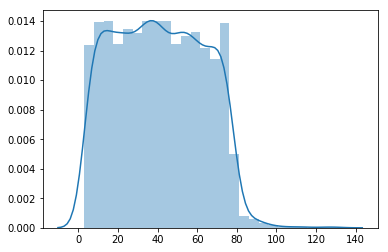

In [9]:
sns.distplot(amplitudes)

In [27]:
mid_point = int((x.shape[1]-1)/2)
R = CONFIG.spike_size
R = 10
MID_POINT_IDX = slice(mid_point - R, mid_point + R + 1)

In [80]:
from yass.augment import util
import pandas as pd

def to_data_frame(array):
    wfs = [a for a in array]
    
    discretized = discretize(util.amplitudes(wfs))
    
    df = pd.DataFrame(data={'waveforms': wfs,
                            'amplitudes': discretized})
    return df

def discretize(amplitudes):
    range_ = int(np.max(amplitudes) - np.min(amplitudes))
    units_per_step = 10
    bins = int(range_ / units_per_step)
    
    discretized = pd.qcut(amplitudes, bins)

    return [interval.right for interval in discretized]

In [81]:
df = to_data_frame(x[slices['templates']])
df.head()

,waveforms,amplitudes
0,"[[-1.3881410238079472, 0.8349387341028447, -1....",13.774
1,"[[-0.203849311368894, -0.0022309525414022503, ...",13.774
2,"[[1.99207208742677, 2.227046446109052, -0.6853...",13.774
3,"[[1.5149752116381185, 0.4154889558828109, 0.89...",24.290
4,"[[-0.2499953014958055, -0.8425221237378019, -0...",24.290


In [82]:
def process_group(g_id, g, model):
    wfs = np.stack(g.waveforms.values, axis=0)
    preds = model.predict(wfs[:, MID_POINT_IDX, :])
    return g_id, preds.mean()

def compute_proportions(x_clean, amplitudes, model):
    # convert to data frame
    df = to_data_frame(x_clean)
    df.sort_values(by='amplitudes', inplace=True)
    
    # group and compute proportion of correct predictions
    vals = [process_group(g_id, g, model) for g_id, g in df.groupby('amplitudes')]
    
    amplitudes, props = list(zip(*vals))
    
    return amplitudes, props

In [83]:
paths = ['/home/Edu/shengao-models/detect_nn_min3max15_noise2.ckpt',
         '/home/Edu/dev/private-yass/nnet/models/detect-11-Jul-2018@21-00-57.ckpt']

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

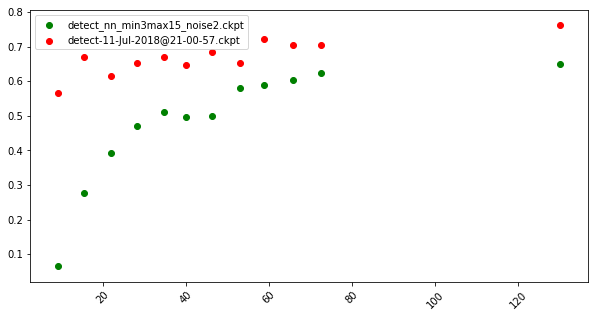

In [84]:
plt.rcParams['figure.figsize'] = (10, 5)

colors = ['g', 'r', 'b', 'k']

# make plots for every model
for i, path_to_model in enumerate(paths):

    # load model
    model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)
    
    # pass spikes and make predictions
    amps, props = compute_proportions(x, amplitudes, model)
    
    # plot results
    plt.scatter(amps, props, color=colors[i],
                label=path_to_model.split('/')[-1])

plt.legend()
plt.xticks(rotation=45)